<a href="https://colab.research.google.com/github/Chrls0806/Project-deep-learning/blob/main/Project_CatiltilandCape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install needed for our deploy, ML or Hugging Face and metrics

In [1]:
!pip install transformers datasets torch scikit-learn comet_ml matplotlib pandas tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.6/764.6 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2


Comet API

In [2]:
COMET_API_KEY = "0NHik5xThTnqkpzpEU81h3LWN"


Train and Deploy

In [19]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from comet_ml import Experiment

Hugging face and ML

In [20]:
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, pipeline
)

logging & metrics

In [21]:
from comet_ml import Experiment
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report, confusion_matrix

In [22]:
csv_path = "/content/Mental Health Dataset.csv"

In [23]:
df = pd.read_csv("Mental Health Dataset.csv")
print(df.columns)
df.head()

Index(['Timestamp', 'Gender', 'Country', 'Occupation', 'self_employed',
       'family_history', 'treatment', 'Days_Indoors', 'Growing_Stress',
       'Changes_Habits', 'Mental_Health_History', 'Mood_Swings',
       'Coping_Struggles', 'Work_Interest', 'Social_Weakness',
       'mental_health_interview', 'care_options'],
      dtype='object')


,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


Utility

In [24]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


Load & split data (80/10/10)

In [25]:
def load_and_split(csv_path, text_col="Growing_Stress", label_col="treatment", seed=42):
    df = pd.read_csv(csv_path)
    assert text_col in df.columns and label_col in df.columns, "Text or label column not found in the dataframe."

    if df[label_col].dtype == object:
        labels = df[label_col].unique().tolist()
        label2id = {l:i for i,l in enumerate(labels)}
        df['treatment'] = df[label_col].map(label2id)
    else:
        labels = sorted(df[label_col].unique().tolist())
        label2id = {l:i for i,l in enumerate(labels)}

    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['treatment'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed, stratify=temp_df['treatment'])

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True), label2id

Verify the split

In [26]:
train_df, val_df, test_df, label2id = load_and_split("Mental Health Dataset.csv")


In [27]:
total = len(train_df) + len(val_df) + len(test_df)

print(f"Train: {len(train_df)} samples ({len(train_df)/total:.1%})")
print(f"Val:   {len(val_df)} samples ({len(val_df)/total:.1%})")
print(f"Test:  {len(test_df)} samples ({len(test_df)/total:.1%})")

print("\nLabel Mapping:", label2id)
print("\nSample data:")
print(train_df[['Growing_Stress', 'treatment']].head())

Train: 233891 samples (80.0%)
Val:   29236 samples (10.0%)
Test:  29237 samples (10.0%)

Label Mapping: {'Yes': 0, 'No': 1}

Sample data:
  Growing_Stress  treatment
0          Maybe          0
1          Maybe          1
2             No          1
3             No          0
4             No          1


Plot bar for visuals

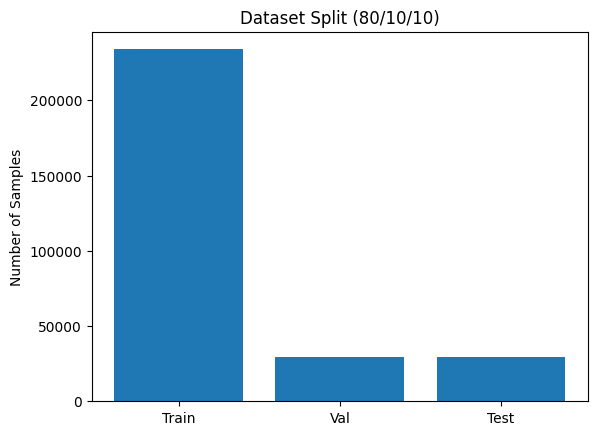

In [28]:
plt.bar(['Train','Val','Test'], [len(train_df), len(val_df), len(test_df)])
plt.title("Dataset Split (80/10/10)")
plt.ylabel("Number of Samples")
plt.show()

Paraphrase augmentation

In [29]:
def paraphrase_dataframe(train_df, paraphrase_model="Vamsi/T5_Paraphrase_Paws", text_col="Growing_Stress", batch_size=8, num_return_sequences=1):

    pp_pipe = pipeline("text2text-generation", model=paraphrase_model, device=0 if torch.cuda.is_available() else -1)

    paras = []
    texts = train_df[text_col].tolist()
    for i in tqdm(range(0, len(texts), batch_size), desc="Paraphrasing"):
        batch_texts = texts[i:i+batch_size]
        prompts = batch_texts
        outputs = pp_pipe(prompts, max_length=128, num_return_sequences=num_return_sequences)

        if isinstance(outputs[0], list):
            for out_list in outputs:
                paras.append(out_list[0]['generated_text'])
        else:
            for out in outputs:
                paras.append(out['generated_text'])

    parap_df = train_df.copy()
    parap_df[text_col] = paras[:len(train_df)]
    augmented_df = pd.concat([train_df, parap_df]).reset_index(drop=True)
    return augmented_df

In [ ]:
augmented_df = paraphrase_dataframe(train_df)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cuda:0
Paraphrasing:   0%|          | 0/29237 [00:00<?, ?it/s]Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transform

In [ ]:
augmented_df[['Growing_Stress', 'treatment']].sample(5)


In [ ]:
from datasets import Dataset

def pandas_to_hfd(df, text_col="Growing_Stress", label_col="treatment"):
    ds = Dataset.from_pandas(df[[text_col, label_col]])
    ds = ds.rename_column(label_col, "labels")
    return ds

def prepare_datasets(tokenizer, train_df, val_df, test_df, text_col="Growing_Stress", label_col="treatment", max_len=128):
    # Convert DataFrames
    train_ds = pandas_to_hfd(train_df, text_col, label_col)
    val_ds = pandas_to_hfd(val_df, text_col, label_col)
    test_ds = pandas_to_hfd(test_df, text_col, label_col)

    # Tokenization function
    def tokenize_fn(batch):
        return tokenizer(batch[text_col], truncation=True, padding='max_length', max_length=max_len)

    # Map tokenizer across datasets
    train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=[text_col])
    val_ds = val_ds.map(tokenize_fn, batched=True, remove_columns=[text_col])
    test_ds = test_ds.map(tokenize_fn, batched=True, remove_columns=[text_col])

    # Convert to PyTorch format
    train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return train_ds, val_ds, test_ds


In [ ]:
print("Loading and splitting data...")
train_df, val_df, test_df, label2id = load_and_split(csv_path)